# Example BANTS application to mock time series data 

Let's demonstrate how to use the `bants` class on a simple mock example. First we need to import `bants` and other modules to make the mock data and do some plotting...

In [1]:
import sys
path = '/Users/Rob/work/bants/' # Give your path to bants here
sys.path.append(path + 'source/')
from bants import bants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tslearn.clustering import TimeSeriesKMeans

/opt/anaconda3/lib/python3.8/site-packages/tslearn/clustering/kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


Now we generate some mock time series data using an n-d Langevin system...

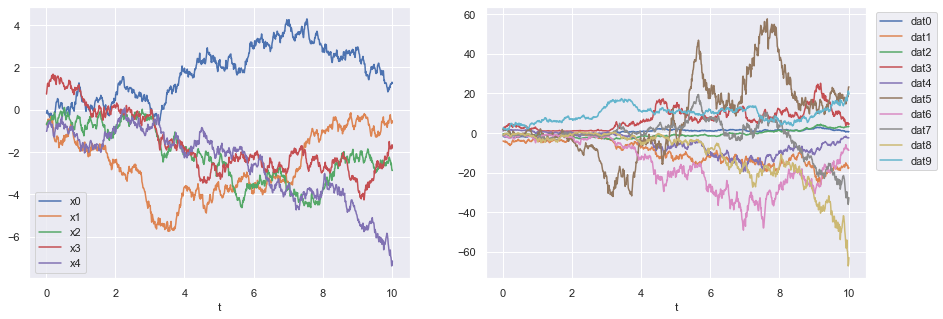

In [2]:
# Evolve the n-d Langevin system
def L_syst_gen(n,runtime,stepsize):    
    # Specify simple drift function with random linear couplings
    def f(x):
        a = np.random.normal(0.0,1.0,size=len(x))
        b = np.random.normal(0.0,1.0,size=len(x))
        return a*x + b*x[np.random.randint(0,len(x),size=len(x))]    
    # Initialise process and run
    t, x = 0.0, np.random.normal(0.0,1.0,size=n)
    out_store = [] 
    while t < runtime:
        t += stepsize
        x += -(stepsize*f(x))+(np.sqrt(stepsize)*np.random.normal(0.0,1.0,size=n))
        out_store.append(np.append(t,x))        
    # Output time series as a pandas dataframe
    out_df = pd.DataFrame(np.asarray(out_store),columns=['t']+['x'+str(ni) for ni in range(0,n)]).set_index('t')
    return out_df
# Choose number of dimensions, total runtime and stepsize
n = 5
runtime = 10.0
stepsize = 0.01
# Run Langevin system and plot output
df = L_syst_gen(n,runtime,stepsize)
# Now add dimensions by creating arbitrary combinations 
# of each column to create a mock degenerate dataset
ndatadim = 10
for i in range(0,ndatadim):
    coeff = np.random.normal(0.0,1.0,size=n)
    power = np.random.randint(0,3,size=n)
    df['dat'+str(i)] = 0.0
    for j in range(0,n):
        df['dat'+str(i)] += coeff[j] * (df['x'+str(j)] ** power[j])
df_comp = df[['x'+str(i) for i in range(0,n)]]
df = df[['dat'+str(i) for i in range(0,ndatadim)]]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df_comp.plot(ax=ax[0])
df.plot(ax=ax[1])
ax[1].legend(bbox_to_anchor=(1.2,1.0))
plt.show()

Let's first apply differencing to the data as a pre-processing step...

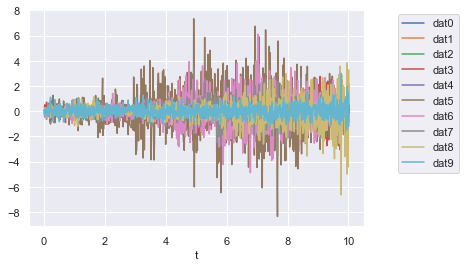

In [3]:
ddf = df.diff().iloc[1:]
ddf.plot()
plt.legend(bbox_to_anchor=(1.3,1.0))
plt.show()

The `bants` class works in the same pattern as a `scikit-learn` estimator. We initialise `bants('KM-GP')` and fit with the `bants.fit` method to the differenced dataframe with the in-built optimiser methods...

Best fit hyperparameters are: {'itmax': 100, 'lnEtol': 0.0001, 'learn_rate': 0.001, 'kmeans_nclus': 5, 'kmeans_max_iter': 10, 'kmeans_random_state': 42, 'nu': 10, 'u': array([ 0.00245745, -0.01304158,  0.00376479,  0.00682478, -0.00347402,
        0.01933842, -0.00761379, -0.03365754, -0.06281962,  0.01421237]), 'U_flat': array([ 0.00212314, -0.01313552,  0.01101052, -0.15345556,  0.46441996,
       -0.08512138,  1.04891763, -0.02481198,  0.0309897 ,  0.04886197,
       -0.00365317,  0.0432777 , -0.0138413 ,  0.1641122 ,  0.03307781,
       -0.2467027 ,  0.03262007,  0.30219769,  0.76253728, -0.24899132,
        0.09384777, -0.03782403,  0.02133985,  0.24832165, -0.04887838,
       -0.15228116, -0.07100921, -0.07001893,  0.08888287, -0.07467273,
        0.00736082,  0.51056879, -0.0672151 , -0.35914908, -0.10367413,
       -0.41486968,  0.0251521 , -0.1389483 ,  0.12661652, -0.09846401,
        0.00825771, -0.04641448, -0.035253  , -0.17892923, -0.02033383,
        0.96555367, -0.05995

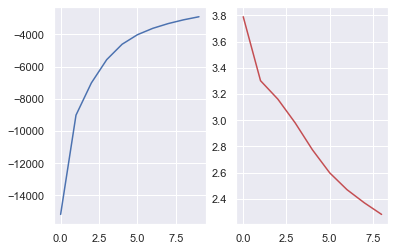

In [4]:
# Initialise class with 'KM-GP' network type (subsequently comment out if iterative runs of the cell are desired)
bts = bants('KM-GP')
# Set the maximum number of algorithm iterations per fitting run and the optimiser - it 
# works quite well to start with 'GD' then finish off with 'Nelder-Mead' near the optimum
bts.optimiser = 'GD' # 'Nelder-Mead'
bts.params['learn_rate'] = 0.001 # Only relevant for 'GD'
bts.params['itmax'] = 100
bts.params['kmeans_nclus'] = 5
bts.params['kmeans_max_iter'] = 10
bts.params['kmeans_random_state'] = 42
nfunc_eval = 0
lnE_vals = []
for i in range(0,10):
    # Apply 'fit' method on the training dataframe to optimise Bayesian network hyperparameters where
    # standardisation of the training data is automatically performed unless the keyword standard=False
    bts.fit(ddf)
    # Update initial parameter values for next run
    bts.u_guess = bts.params['u']
    bts.U_flat_guess = bts.params['U_flat']
    bts.Psi_tril_guess = bts.params['Psi_tril']
    # Store the log-evidence values from the run and add to the total number of function evaluations
    lnE_vals.append(bts.info['lnE_val'])
    nfunc_eval += bts.info['n_evaluations']
# Display the best fit hyperparameters
print('Best fit hyperparameters are: ' + str(bts.params))
# Display the best fit log-evidence value
print('Best fit log-evidence value is: ' + str(bts.info['lnE_val']))
# Ask if the fitting converged
print('Converged?: ' + str(bts.info['converged']))
# Display the number of function evaluations
print('Number of function evaluations: ' + str(nfunc_eval))
# Plot intermediate values and base-10 logarithmic improvements in the log-evidence after each run
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(lnE_vals,color='b')
ax2.plot(np.log10(np.asarray(lnE_vals)[1:]-np.asarray(lnE_vals)[:-1]),color='r')
plt.show()

Applying the `bants.predict` method, the fitted Bayesian network model can be used to generate predictive samples into the future...

In [5]:
# Future timepoint to sample up to
future_t = 10.1 # 10.3
# Number of prediction samples to generate at each timepoint
n_samples = 1000
# Apply bants.predict to forecast time series up to future time 
# from training data last timepoint index using the MAP network
pred_samps = bts.predict(future_t, n_samples, compute_map=True, kmeans_window=50)

...and we can now plot the predictive contours...

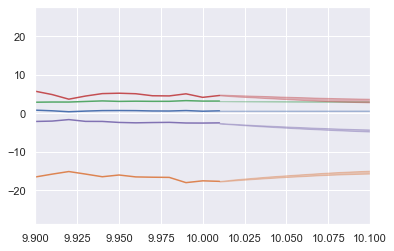

In [9]:
# Store colour palette
cp = sns.color_palette()
# Loop over dimensions of time series for plot
for i in range(0,5):
    # Cumulative sum of samples (integration) to remove differencing (remember to append training points to this!)
    fp = np.tensordot(df.values[0,i]*np.ones(1),np.ones(n_samples),axes=0) # First point
    dtd = np.tensordot(ddf.values[:,i],np.ones(n_samples),axes=0) # Differenced training data
    diff_preds = np.append(fp,np.append(dtd,pred_samps[:,i,:],axis=0),axis=0) # Append along time axis
    isamps = np.cumsum(diff_preds,axis=0)[-pred_samps.shape[0]:]
    # Compute 68% confidence
    c68l, c68u = np.quantile(isamps,[0.16,0.84],axis=1)
    # Use these to plot contours
    plt.plot(df.index,df.values[:,i],color=cp[i])
    plt.fill_between(np.arange(runtime+stepsize,future_t+stepsize,stepsize),c68l,c68u,alpha=0.4,color=cp[i])
# Modify time axis for clearer display
axes = plt.gca()
axes.set_xlim([(2*runtime)-future_t,future_t])
plt.show()